<a href="https://colab.research.google.com/github/EastWon0103/Data_Science_P2/blob/main/%EA%B9%80%EB%8F%99%EC%9B%90_20181580_p02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from math import sqrt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## **Task 1. (15 점) 데이터 준비하기**

In [ ]:
'''
Task 1-1. (5 점) 파일을 다운로드 받고 (requests, zipfile 사용), ratings.csv 파일을 읽어서 80%
20% 비율의 train, test 데이터로 나누기
'''

url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

r = requests.get(url)

open("ml-latest-small.zip", "wb").write(r.content)
zipfile.ZipFile("ml-latest-small.zip").extractall("./")

ratings_pd = pd.read_csv("./ml-latest-small/ratings.csv")

# sklearn의 train_test_split 사용
r_train, r_test = train_test_split(ratings_pd, test_size=0.2, shuffle=True)

display(r_train)
display(r_test)

,userId,movieId,rating,timestamp
28179,195,2155,5.0,974707634
66673,429,186,4.0,828124616
60445,391,417,4.0,1030827326
20243,132,45499,3.0,1157921423
80442,509,2018,3.0,1436000068
...,...,...,...,...
56333,372,1374,3.0,874415902
54248,357,1271,4.5,1348628295
81917,517,135143,3.5,1487966240
92489,597,2403,5.0,941728937


,userId,movieId,rating,timestamp
48470,313,2791,3.0,1030557675
92678,599,144,2.5,1519343783
83077,525,112852,4.5,1476475958
68682,448,163,3.5,1074420419
19082,122,97306,4.0,1461562618
...,...,...,...,...
40081,274,6755,3.5,1197015172
93812,599,4125,0.5,1519124389
7995,56,110,4.0,835799188
38614,265,2527,4.0,965314838


In [ ]:
'''
Task 1-2. (5 점) movies.csv 파일을 읽고, 장르를 집합으로 변환하기
'''

movies =  pd.read_csv("./ml-latest-small/movies.csv")

def str_to_set(x):
  genre_set = set()
  for item in x.split('|'):
    genre_set.add(item)
  return genre_set

movies.genres = movies.genres.apply(str_to_set)
display(movies.genres)

0       {Adventure, Children, Fantasy, Animation, Comedy}
1                          {Adventure, Children, Fantasy}
2                                       {Romance, Comedy}
3                                {Romance, Comedy, Drama}
4                                                {Comedy}
                              ...                        
9737                 {Animation, Comedy, Fantasy, Action}
9738                         {Animation, Comedy, Fantasy}
9739                                              {Drama}
9740                                  {Animation, Action}
9741                                             {Comedy}
Name: genres, Length: 9742, dtype: object

In [ ]:
'''
Task 1-3. (5 점) tags.csv 파일을 읽고, tag들을 모두 소문자로 변환 후, 영화별로 tag들을 묶어서
집합으로 변환하기 (예: 122912번 영화(Avengers: Infinity War - Part I)의 tag집합 = {visually
stunning, visually appealing, thor, thanos, sad, robert downey jr., mcu, marvel, guardians of
the galaxy, great villain, emotional, dr. strange, dark, comic book})
'''
tags = pd.read_csv("./ml-latest-small/tags.csv")
#tags = tags_ori.groupby("movieId").max()

temp_dict = {}
for i in tags.index:
  movieId = tags.loc[i].movieId
  tag = str(tags.loc[i].tag).lower()
  if movieId in temp_dict:
    temp_dict[movieId].add(tag)
  else:
    temp_dict[movieId] = set()
    temp_dict[movieId].add(tag)

tags = pd.DataFrame({"movieId":temp_dict.keys(),
                    "tags":temp_dict.values()
})


avg = tags[tags["movieId"] == 122912]
print("Avengers tags")
for i in avg.tags.values[0]:
  print(i)

Avengers tags
visually stunning
visually appealing
mcu
great villain
dark
comic book
sad
thor
dr. strange
guardians of the galaxy
emotional
marvel
robert downey jr.
thanos


In [ ]:
meta = pd.merge(movies, tags, on="movieId", how="outer")

meta

,movieId,title,genres,tags
0,1,Toy Story (1995),"{Adventure, Children, Fantasy, Animation, Comedy}","{pixar, fun}"
1,2,Jumanji (1995),"{Adventure, Children, Fantasy}","{game, magic board game, robin williams, fantasy}"
2,3,Grumpier Old Men (1995),"{Romance, Comedy}","{moldy, old}"
3,4,Waiting to Exhale (1995),"{Romance, Comedy, Drama}",NaN
4,5,Father of the Bride Part II (1995),{Comedy},"{pregnancy, remake}"
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"{Animation, Comedy, Fantasy, Action}",NaN
9738,193583,No Game No Life: Zero (2017),"{Animation, Comedy, Fantasy}",NaN
9739,193585,Flint (2017),{Drama},NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"{Animation, Action}",NaN


#**Task 2. (25 점) Latent Factor 모델을 이용하여 학습하기**

Task 2. (25 점) Latent Factor 모델을 이용하여 학습하기


● Task 2-1. (20 점) P, Q 등 파라미터 초기화 후, optimizer 

등을 이용해서 학습하기


○ 기본 5점


○ (+5 점) bias 추가


○ (+5 점) regularization 추가


○ (+5 점) hyper parameter (learning rate, regularization 
weight 등) 탐색


● Task 2-2. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training
RMSE, test RMSE)


In [ ]:
class LatentFactor: 
  def __init__(self, items, users, ratings, v_items, v_users, v_ratings, rank, lr, lmd1, lmd2, epoch):
    self.epo_lst = []
    self.cost_lst = []
    self.cost_test_lst = []

    self.numItems = items.max()+1
    self.numUsers = users.max()+1

    self.rank = rank
    self.epoch = epoch
    self.lr = lr
    self.lmd1 = lmd1
    self.lmd2 = lmd2

    self.lmd3 = self.lmd1
    self.lmd4 = self.lmd2

    self.mean = (ratings.sum() / len(ratings)).item()

    self.P = torch.randn(self.numItems, self.rank, requires_grad=True)
    self.Q = torch.randn(self.numUsers, self.rank, requires_grad=True)

    self.bias_item = torch.randn(self.numItems, requires_grad=True)
    self.bias_user = torch.randn(self.numUsers, requires_grad=True)

    self.optim = torch.optim.Adam([self.P, self.Q, self.bias_item, self.bias_user], self.lr)

    pbar = tqdm(range(epoch))
    for e in pbar:
      hypo = torch.sum(self.P[items]*self.Q[users], dim=1)+self.mean+ self.bias_item[items] + self.bias_user[users]
      cost = (F.mse_loss(hypo, ratings))**0.5
      loss = cost+self.lmd1*torch.sum(self.P**2)+ self.lmd2*torch.sum(self.Q**2)+self.lmd3*torch.sum(self.bias_item**2)+self.lmd4*torch.sum(self.bias_user**2)
      
      self.optim.zero_grad()
      loss.backward()
      self.optim.step()

      self.epo_lst.append(e)
      self.cost_lst.append(cost)
      with torch.no_grad():
        hypo_test = torch.sum(self.P[v_items]*self.Q[v_users], dim=1)+self.mean+ self.bias_item[v_items] + self.bias_user[v_users]
        cost_test = sqrt(F.mse_loss(hypo_test, v_ratings))
        self.cost_test_lst.append(cost_test)

      pbar.set_description(f"Cost: {cost:.4f}")

  
  def predict(self, items, users):
    rating =  hypo = torch.sum(self.P[items]*self.Q[users], dim=1)+self.mean+ self.bias_item[items] + self.bias_user[users]
    return rating



    

In [ ]:
items = torch.LongTensor(r_train["movieId"].values)
users = torch.LongTensor(r_train["userId"].values)
ratings = torch.FloatTensor(r_train["rating"].values)

items_test = torch.LongTensor(r_test["movieId"].values)
users_test = torch.LongTensor(r_test["userId"].values)
ratings_test = torch.FloatTensor(r_test["rating"].values)

# 하이퍼 파라미터 탐색

print("rank 10, lr=0.1, lmd 0.0001")
model1 = LatentFactor(items, users, ratings, items_test, users_test, ratings_test, 10, 0.1, 0.0001, 0.0001, 1000)
print()


items = torch.LongTensor(r_train["movieId"].values)
users = torch.LongTensor(r_train["userId"].values)
ratings = torch.FloatTensor(r_train["rating"].values)

items_test = torch.LongTensor(r_test["movieId"].values)
users_test = torch.LongTensor(r_test["userId"].values)
ratings_test = torch.FloatTensor(r_test["rating"].values)

print("rank 5, lr=0.5, lmd 0.01")
model2 = LatentFactor(items, users, ratings, items_test, users_test, ratings_test, 3, 0.5, 0.001, 0.001, 1000)
print()

items = torch.LongTensor(r_train["movieId"].values)
users = torch.LongTensor(r_train["userId"].values)
ratings = torch.FloatTensor(r_train["rating"].values)

items_test = torch.LongTensor(r_test["movieId"].values)
users_test = torch.LongTensor(r_test["userId"].values)
ratings_test = torch.FloatTensor(r_test["rating"].values)

print("rank 30, lr=1.0, lmd 0.1")
model3 = LatentFactor(items, users, ratings, items_test, users_test, ratings_test, 30, 1.0, 0.1, 0.1, 500)
print()


rank 10, lr=0.1, lmd 0.0001


Cost: 0.6611: 100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]



rank 5, lr=0.5, lmd 0.01


Cost: 0.9251: 100%|██████████| 1000/1000 [00:34<00:00, 28.84it/s]



rank 30, lr=1.0, lmd 0.1


Cost: 1.0380: 100%|██████████| 500/500 [01:16<00:00,  6.50it/s]

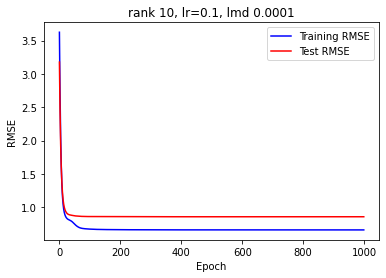

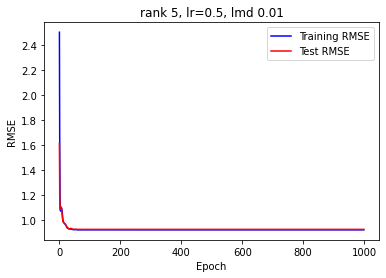

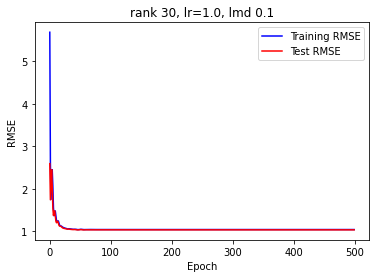

In [ ]:
'''
Task 2-2. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training
RMSE, test RMSE)
'''
plt.title("rank 10, lr=0.1, lmd 0.0001")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.plot(model1.epo_lst, model1.cost_lst, c="blue", label="Training RMSE")
plt.plot(model1.epo_lst,model1.cost_test_lst, c="red", label="Test RMSE")
plt.legend()
plt.show()


plt.title("rank 5, lr=0.5, lmd 0.01")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.plot(model2.epo_lst, model2.cost_lst, c="blue", label="Training RMSE")
plt.plot(model2.epo_lst,model2.cost_test_lst, c="red", label="Test RMSE")
plt.legend()
plt.show()

plt.title("rank 30, lr=1.0, lmd 0.1")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.plot(model3.epo_lst, model3.cost_lst, c="blue", label="Training RMSE")
plt.plot(model3.epo_lst,model3.cost_test_lst, c="red", label="Test RMSE")
plt.legend()
plt.show()


#**Task 3. (20 점) 514번 User에게 추천하기 (knn search, similarity)**

In [ ]:
merged_rating = pd.merge(ratings_pd, movies[["movieId", "title"]], on="movieId", how="inner")
merged_rating = merged_rating.sort_values(by=["userId", "movieId"])
user_table = merged_rating.pivot_table(index="userId", columns="title", values="rating")

In [ ]:
'''
Task 3-1. (10 점) 514번 user의 예상 별점이 가장 높은 영화 20개를 찾아서 id 및 영화 이름 출력하기
'''
# 아직 평점을 매기지 않은 영화들
user_514_rating = user_table.loc[514].to_frame(name="rating").dropna(axis=0)
user_514_rating = user_514_rating.reset_index()

merge_temp = pd.merge(movies[["movieId", "title"]], user_514_rating, on="title", how="outer")
not_rated = merge_temp.loc[merge_temp["rating"].isna()]

user_514_movie = torch.LongTensor(not_rated.movieId.values)
user_514 = torch.LongTensor([514])
result_tensor = np.round(model1.predict(user_514_movie, user_514).detach().numpy(), 2)

user_514_list = not_rated.loc[:,["movieId", "title"]]
user_514_list["rating"] = result_tensor

user_514_list = user_514_list.sort_values(by=["rating"] , ascending=False)

display(user_514_list.iloc[0:20])



,movieId,title,rating
461,527,Schindler's List (1993),5.52
277,318,"Shawshank Redemption, The (1994)",4.83
695,912,Casablanca (1942),4.47
660,858,"Godfather, The (1972)",4.40
97,110,Braveheart (1995),4.34
923,1221,"Godfather: Part II, The (1974)",4.31
3624,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.30
906,1203,12 Angry Men (1957),4.28
962,1262,"Great Escape, The (1963)",4.28
910,1208,Apocalypse Now (1979),4.22


In [ ]:
def jaccard_similarity(s1, s2):
  if len(s1|s2) == 0:
    return 0
  return len(s1&s2)/len(s1|s2)

In [ ]:
def pearson_similarity(u1, u2):
  u1_c = u1 - u1.mean()
  u2_c = u2 - u2.mean()
  denom = np.sqrt(np.sum(u1_c**2)*np.sum(u2_c**2))
  if denom != 0:
    return np.sum(u1_c*u2_c)/denom
  else:
    return 0

In [ ]:
def find_similar_movies(input_title, matrix, meta_db, n, alpha):
  input_meta = meta_db.loc[meta_db["title"] == input_title].iloc[0]
  try:
    input_set = input_meta.genres | input_meta.tags
  except:
    input_set = input_meta.genres
  result = []

  for this_title in matrix.columns:
    if this_title == input_title:
      continue
    
    this_meta = meta.loc[meta["title"]==this_title].iloc[0]
    try:
      this_set = this_meta.genres | this_meta.tags
    except:
      this_set = this_meta.genres
    
    pearson = pearson_similarity(matrix[this_title], matrix[input_title])
    jaccard = jaccard_similarity(this_set, input_set)

    score = alpha*pearson + (1-alpha)*jaccard
    result.append((this_title, pearson, jaccard, score))

  result.sort(key=lambda r:r[3], reverse=True)
  return result[:n]

In [ ]:
#5점짜리 영화 
list_5_514 = user_table.loc[514, user_table.loc[514] == 5]
list_5_514



title
Aliens (1986)                                                                     5.0
Back to the Future (1985)                                                         5.0
Charlie Brown Christmas, A (1965)                                                 5.0
Close Encounters of the Third Kind (1977)                                         5.0
Field of Dreams (1989)                                                            5.0
How the Grinch Stole Christmas! (1966)                                            5.0
Jaws (1975)                                                                       5.0
Miracle on 34th Street (1947)                                                     5.0
Princess Bride, The (1987)                                                        5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Silence of the Lambs, The (1991)                                                  5.0
Social Network, The (2010)                      

In [ ]:
'''
Task 3-2. (10 점) 장르 및 tag를 기준으로, 514번 user가 5점을 준 영화들을 찾고, 각각의 영화와 
가장 유사한 영화를 5개씩 찾아서 id, 영화 이름, 유사도 점수 출력하기
'''
for title in list_5_514.index.values:
  result = find_similar_movies(title, user_table, meta, 5, 0.3)
  print(title)
  df = pd.DataFrame(result, columns = ['title', 'pearson', 'jaccard', 'score'])
  display(df)
  print()

Aliens (1986)


,title,pearson,jaccard,score
0,Alien (1979),0.520444,0.250000,0.331133
1,Mad Max (1979),0.269728,0.250000,0.255918
2,Star Wars: Episode III - Revenge of the Sith (...,0.086654,0.307692,0.241381
3,Terminator 2: Judgment Day (1991),0.282022,0.222222,0.240162
4,Independence Day (a.k.a. ID4) (1996),0.074861,0.307692,0.237843



Back to the Future (1985)


,title,pearson,jaccard,score
0,Back to the Future Part II (1989),0.402208,1.00,0.820663
1,Bill & Ted's Excellent Adventure (1989),0.141722,1.00,0.742517
2,Bill & Ted's Bogus Journey (1991),0.111485,0.80,0.593445
3,Time Bandits (1981),0.086562,0.80,0.585969
4,"Hitchhiker's Guide to the Galaxy, The (2005)",0.113564,0.75,0.559069



Charlie Brown Christmas, A (1965)


,title,pearson,jaccard,score
0,"It's the Great Pumpkin, Charlie Brown (1966)",0.179284,1.0,0.753785
1,Hotel Transylvania (2012),0.076143,1.0,0.722843
2,"Smurfs 2, The (2013)",0.043301,1.0,0.712990
3,Cars (2006),0.029442,1.0,0.708833
4,Chicken Run (2000),0.016735,1.0,0.705020



Close Encounters of the Third Kind (1977)


,title,pearson,jaccard,score
0,"20,000 Leagues Under the Sea (1954)",0.089574,1.0,0.726872
1,Until the End of the World (Bis ans Ende der W...,0.063060,1.0,0.718918
2,Guest from the Future (Gostya iz buduschego) (...,0.000000,1.0,0.700000
3,"Philadelphia Experiment, The (1984)",0.000000,1.0,0.700000
4,Enemy Mine (1985),-0.001219,1.0,0.699634



Field of Dreams (1989)


,title,pearson,jaccard,score
0,Bogus (1996),0.044089,0.75,0.538227
1,"Christmas Carol, A (1938)",0.019181,0.75,0.530754
2,FairyTale: A True Story (1997),0.000000,0.75,0.525000
3,Prancer (1989),0.000000,0.75,0.525000
4,MirrorMask (2005),0.159845,0.60,0.467953



How the Grinch Stole Christmas! (1966)


,title,pearson,jaccard,score
0,Allegro non troppo (1977),0.000000,1.00,0.700000
1,Yellow Submarine (1968),0.042216,0.80,0.572665
2,Frosty the Snowman (1969),0.000000,0.80,0.560000
3,Monkeybone (2001),0.000838,0.75,0.525252
4,Anomalisa (2015),0.000000,0.75,0.525000



Jaws (1975)


,title,pearson,jaccard,score
0,Jaws 3-D (1983),0.039068,1.000000,0.711721
1,"Crow: Salvation, The (2000)",0.080979,0.666667,0.490960
2,Dog Soldiers (2002),0.047010,0.666667,0.480770
3,Outpost (2008),0.040934,0.666667,0.478947
4,Alone in the Dark II (2008),0.000000,0.666667,0.466667



Miracle on 34th Street (1947)


,title,pearson,jaccard,score
0,Beautiful (2000),0.211075,1.0,0.763323
1,Roommates (1995),0.184242,1.0,0.755272
2,"Full Monty, The (1997)",0.165979,1.0,0.749794
3,Varsity Blues (1999),0.164630,1.0,0.749389
4,Where the Heart Is (2000),0.158581,1.0,0.747574



Princess Bride, The (1987)


,title,pearson,jaccard,score
0,"Librarian: Quest for the Spear, The (2004)",0.056184,0.714286,0.516855
1,Stardust (2007),0.178100,0.571429,0.453430
2,"Jewel of the Nile, The (1985)",0.136757,0.571429,0.441027
3,Romancing the Stone (1984),0.122592,0.571429,0.436778
4,Mr. & Mrs. Smith (2005),0.106197,0.571429,0.431859



Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)


,title,pearson,jaccard,score
0,Indiana Jones and the Last Crusade (1989),0.375331,0.333333,0.345933
1,Indiana Jones and the Temple of Doom (1984),0.195338,0.333333,0.291935
2,Tomb Raider (2018),0.323352,0.272727,0.287915
3,Avengers: Age of Ultron (2015),0.326116,0.222222,0.253390
4,War for the Planet of the Apes (2017),0.306664,0.200000,0.231999



Silence of the Lambs, The (1991)


,title,pearson,jaccard,score
0,Session 9 (2001),0.050685,0.363636,0.269751
1,American Psycho (2000),0.133189,0.300000,0.249957
2,I Spit on Your Grave (2010),0.049661,0.333333,0.248232
3,Henry: Portrait of a Serial Killer (1986),0.047364,0.333333,0.247542
4,From Hell (2001),0.106384,0.300000,0.241915



Social Network, The (2010)


,title,pearson,jaccard,score
0,Departures (Okuribito) (2008),0.365611,0.25,0.284683
1,"Blind Side, The (2009)",0.355001,0.25,0.281500
2,12 Years a Slave (2013),0.337387,0.25,0.276216
3,I Am Sam (2001),0.322791,0.25,0.271837
4,Shame (2011),0.310340,0.25,0.268102



Star Wars: Episode IV - A New Hope (1977)


,title,pearson,jaccard,score
0,Star Wars: Episode VI - Return of the Jedi (1983),0.533030,0.285714,0.359909
1,Star Wars: Episode V - The Empire Strikes Back...,0.568797,0.259259,0.352121
2,Star Wars: Episode III - Revenge of the Sith (...,0.076833,0.238095,0.189717
3,Aliens (1986),0.077684,0.222222,0.178861
4,Journey to the Center of the Earth (2008),0.185559,0.142857,0.155668



Star Wars: Episode V - The Empire Strikes Back (1980)


,title,pearson,jaccard,score
0,Star Wars: Episode IV - A New Hope (1977),0.568797,0.259259,0.352121
1,Star Wars: Episode VI - Return of the Jedi (1983),0.465596,0.266667,0.326346
2,Star Wars: Episode III - Revenge of the Sith (...,0.149008,0.384615,0.313933
3,War for the Planet of the Apes (2017),0.288992,0.214286,0.236698
4,Avengers: Age of Ultron (2015),0.235265,0.230769,0.232118



WarGames (1983)


,title,pearson,jaccard,score
0,Deep Impact (1998),0.196754,0.75,0.584026
1,"Thirteenth Floor, The (1999)",0.159813,0.75,0.572944
2,Ex Machina (2015),0.010331,0.75,0.528099
3,Communion (1989),0.000000,0.75,0.525000
4,"Happening, The (2008)",0.000000,0.75,0.525000


#**Task 4. (15 점) 영화 클러스터링하기(k-means clustering)**

In [ ]:
rated = ratings_pd.groupby("movieId").max()

r_item = torch.LongTensor(rated.index)
rated_P = model1.P[r_item]
rated_P = np.array(rated_P.detach().numpy())
# rated_P = []

# for i in rated.index.values:
#    rated_P.append(np.array(P[i-1].detach().numpy()))

# rated_P = np.array(rated_P)

In [ ]:
rated

,userId,rating,timestamp
movieId,,,
1,610,5.0,1535709666
2,608,5.0,1529901723
3,608,5.0,1498505071
4,600,3.0,1237760055
5,604,5.0,1517441319
...,...,...,...
193581,184,4.0,1537109082
193583,184,3.5,1537109545
193585,184,3.5,1537109805


In [ ]:
def cos_sim(A,B):
  reusult = np.dot(A, B) / (np.linalg.norm(A)*np.linalg.norm(B))
  if not np.isnan(result) or result != np.inf
  return result

def kmeans(points, k, max_iters=10):
  """
    return labels, cluster_centers

    1. cluster_center를 랜덤하게 생성
    2. 각가의 점마다 어떤 cluster center와 가장 가까운지 계산 및 할당 
    3. 새로운 labelsㅇ을 이용해서, cluster_center 새로 계싼
    4. 2-3 반복하다가... 더이상 업데이트가 없으면 종료
  """
  cluster_centers = points[np.random.choice(points.shape[0], k, replace=False)]

  for iter in range(max_iters):
  
    labels = []

    for p in points:
      min_dist = 100
      min_cid = -1
      for cid, c in enumerate(cluster_centers):
        dist = cos_sim(p,c)
        if dist < min_dist:
          min_dist = dist
          min_cid = cid

      labels.append(min_cid)

    labels = np.array(labels)


    new_cluster_centers = np.zeros_like(cluster_centers)
    counts = np.zeros(k)

    for l, p in zip(labels, points):
      new_cluster_centers[l] += p
      counts[l] += 1

    for i in range(k):
      new_cluster_centers[i] /= counts[i]

    if np.array_equal(cluster_centers, new_cluster_centers):
      break
    else:
      cluster_centers = new_cluster_centers
  
  return labels, cluster_centers

Task 4-1. (5 점) cosine similarity를 기준으로 영화 벡터 (P혹은 Q)에서 k-means clustering
구하기 (k=1, ..., 40 까지 바꿔가면서 cost 값을 계산)

In [ ]:
r_x = np.array(range(1,41))
r_y = []

for k in tqdm(range(1, 41)):
  labels, centered = kmeans(rated_P, k)
  cost = 0
  for i in range(len(labels)):
    cos = cos_sim(centered[labels[i]],rated_P[i])
    if not np.isnan(cos):
      cost += (1 - cos)**0.5
  r_y.append(cost)
    

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 40/40 [19:10<00:00, 28.75s/it]


Task 4-2. (5 점) Task 4-1에서 구한 결과를 matplotlib를 활용하여 그래프로 그린 후 가장 적절해
보이는 k값 선택하기

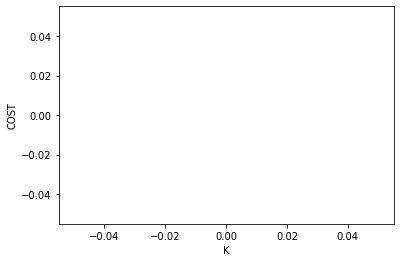

In [ ]:
#코스트느 1-cos_sim 으로 정의함
plt.ylabel("COST")
plt.xlabel("K")
plt.plot(r_x, r_y)
plt.show()

Task 4-3. (5 점) 122912번 영화(Avengers: Infinity War - Part I)와 같은 cluster에 속한 다른 영화
중 cosine similarity가 가장 높은 영화 20개를 찾아서 id, 영화 이름, 유사도 점수 출력하기


In [ ]:
avg_pos = 0
for mvid in rated.index: #어벤져스 movie Id(index)의 rated에서 위치 알기
  if mvid == 122912:
    break
  avg_pos+=1
labels, centered = kmeans(rated_P, 40)

avg_label = labels[avg_pos]
avg_point = rated_P[avg_pos]

same_label_lst = []

for i in range(len(labels)):
  mvid = rated.index.values[i]
  if labels[i] == avg_label:
    cos = cos_sim(avg_point, rated_P[i])
    if cos < 1:
      same_label_lst.append([mvid, movies[movies["movieId"]==mvid].title.values[0], cos_sim(avg_point, rated_P[i])])


In [ ]:
score_board = pd.DataFrame(same_label_lst, columns=["movieId", "title", "score"])
score_board = score_board.sort_values(by=["score"] , ascending=False)
score_board.iloc[1:21]

,movieId,title,score
118,64575,Doubt (2008),0.882286
166,166291,A Silent Voice (2016),0.810376
71,6818,Come and See (Idi i smotri) (1985),0.802759
87,25771,"Andalusian Dog, An (Chien andalou, Un) (1929)",0.798524
145,117887,Paddington (2014),0.798078
170,168218,Kizumonogatari III: Cold Blood (2017),0.785067
161,157369,Bakuman (2015),0.785040
172,170907,Betting on Zero (2016),0.785029
176,173235,Tokyo Idols (2017),0.785029
187,191005,Gintama (2017),0.785028


#**Task 5. (25 점) 차원 축소 및 시각화 (PCA)**

Task 5-1. (5 점) P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

In [ ]:
print(rated_P.shape)
print(model1.Q.shape)

Z = torch.cat([torch.LongTensor(rated_P), model1.Q], dim=0)

Z.shape

(9724, 10)
torch.Size([611, 10])


torch.Size([10335, 10])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

predict = pca.fit_transform(Z.detach().numpy())

x = []
y = []
for i, j in predict:
  x.append(i)
  y.append(j)

p_x = x[:len(rated_P)]
p_y = y[:len(rated_P)]

q_x = x[len(rated_P):]
q_y = y[len(rated_P):]

label = []
for i in range(len(x)):
  if i <= len(rated_P)/2:
    label.append(0)
  else:
    label.append(2)

plt.scatter(x,y, c=label)
plt.show()

# plt.scatter(p_x, p_y, c="red")
# plt.scatter(q_x, q_y)
# plt.legend()
# plt.show()